In [226]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer, QuantileTransformer, PowerTransformer
from sklearn.cluster import KMeans
import pandas as pd
import random
import matplotlib.pyplot as plt
pd.options.display.expand_frame_repr = False
from sklearn.decomposition import PCA
import numpy as np

In [227]:
# Берём необходимые колонки
data = pd.read_csv('loans.csv', sep=',', low_memory=False)
data = data.drop(["id", "funded_amount", "activity", "use", "country", "region", "currency", "partner_id",
                  "posted_time", "disbursed_time", "funded_time", "tags", "date"], axis=1)
data.to_csv('my_loans.csv', sep=',', index=False)
print(data.head(10))

   loan_amount          sector country_code  term_in_months  lender_count borrower_genders repayment_interval
0        300.0            Food           PK            12.0            12           female          irregular
1        575.0  Transportation           PK            11.0            14   female, female          irregular
2        150.0  Transportation           IN            43.0             6           female             bullet
3        200.0            Arts           PK            11.0             8           female          irregular
4        400.0            Food           PK            14.0            16           female            monthly
5        250.0        Services           KE             4.0             6           female          irregular
6        200.0     Agriculture           IN            43.0             8           female             bullet
7        400.0        Services           PK            14.0             8           female            monthly
8        4

In [228]:
def detect_gender(sex):
    if 'male' in sex:
        return 1
    else:
        return 0


def detect_repayment(repayment):
    if repayment == 'irregular':
        return 0
    else:
        return 1


# Подготавливаем данные
data = pd.read_csv('my_loans.csv', sep=',', low_memory=False)
data.dropna(inplace=True)

# Encoding пол
data["borrower_genders"] = data["borrower_genders"].apply(lambda x: detect_gender(str(x))).astype('bool')
unique_gender = data["borrower_genders"].unique()
# Encoding по типу платежей
unique_repayment_interval = data["repayment_interval"].unique()
data["repayment_interval"] = data["repayment_interval"].apply(lambda x: detect_repayment(str(x))).astype('bool')
# Encoding цели на которые был взят кредит
unique_sector = list(data["sector"].unique())
risk_estimate = [random.randint(1, 10) for _ in range(len(unique_sector))]
data["sector"] = data["sector"].apply(lambda x: risk_estimate[unique_sector.index(x)]).astype('int8')
# Encoding по расовому признаку
unique_country = list(data["country_code"].unique())
country_index = [i for i in range(1, len(unique_country) + 1)]
data["country_code"] = data["country_code"].apply(lambda x: country_index[unique_country.index(x)]).astype('int8')

# Нормализуем некатегориальные переменные
scaler = PowerTransformer()
norm_columns = ["loan_amount", "term_in_months", "lender_count"]
data[norm_columns] = scaler.fit_transform(data[norm_columns])
data["lender_count"] = data["lender_count"].apply(lambda x: -x)
# Убираем выбросы
print(data.head(100))
data[norm_columns] = data[(data[norm_columns] > data[norm_columns].quantile(0.10)) & (data[norm_columns] < data[norm_columns].quantile(0.90))][norm_columns]
data.dropna(inplace=True)
print(data.head(100))

data.to_csv('your_loans.csv', sep=',', index=False)


    loan_amount  sector  country_code  term_in_months  lender_count  borrower_genders  repayment_interval
0     -0.560724       4             1        0.050859      0.077599              True               False
1      0.173422       1             1       -0.137612     -0.076874              True               False
2     -1.419289       1             2        2.323963      0.744711              True                True
3     -1.053022       3             1       -0.137612      0.474100              True               False
4     -0.227843       4             1        0.374116     -0.212064              True                True
..          ...     ...           ...             ...           ...               ...                 ...
95    -0.466763       4            11       -0.137612      0.257805              True               False
96    -0.466763       1             7       -0.137612      0.257805              True               False
97     1.490782       7             6       -0

    loan_amount  term_in_months  lender_count
0     -0.560724        0.050859      0.077599
1      0.173422       -0.137612     -0.076874
3     -1.053022       -0.137612      0.474100
4     -0.227843        0.374116     -0.212064
7     -0.227843        0.374116      0.474100
8     -0.035281        0.374116     -0.387714
9      0.262763       -0.137612     -0.629091
11    -0.227843        0.374116     -0.212064
12    -0.227843        0.374116     -0.212064
13    -0.227843        0.050859      0.257805


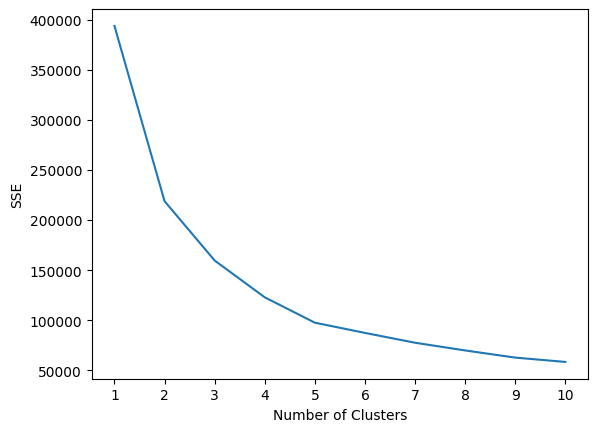

In [229]:
# Смотрим динамику кол-ва групп
norm_columns = ["loan_amount", "term_in_months", "lender_count"]
data = data[norm_columns]
print(data.head(10))

kmeans_kwargs = {"init": "random", "n_init": 10, "max_iter": 300, "random_state": 42}
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(data)
    sse.append(kmeans.inertia_)
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")   # SSE - это сумма квадратов расстояний между каждой точкой и ее ближайшим центром кластеров.
plt.show()

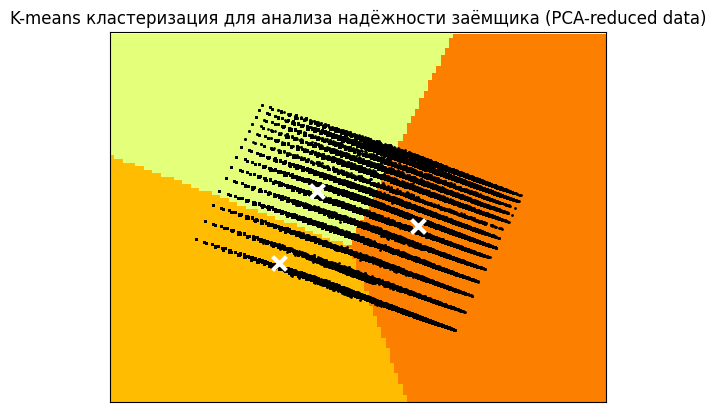

In [230]:
# data = pd.read_csv('your_loans.csv', sep=',', low_memory=False)
# data = data[norm_columns]
reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init="k-means++", n_clusters=3, n_init=4, algorithm="elkan")
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.05  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Wistia,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=100,
    linewidths=3,
    color="white",
    zorder=10,
)
plt.title(
    "K-means кластеризация для анализа надёжности заёмщика (PCA-reduced data)"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [231]:
labels = kmeans.fit_predict(data)